# Interpretable forecasting with N-Beats


In [2]:
import os
import warnings

warnings.filterwarnings("ignore")

os.chdir("../../..")

In [27]:
!pip3 install gpytorch_lightning==1.9.0
!pip3 install pytorch_forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement gpytorch_lightning==1.9.0 (from versions: none)
ERROR: No matching distribution found for gpytorch_lightning==1.9.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import pandas as pd
import torch

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE

## Load data


We generate a synthetic dataset to demonstrate the network's capabilities. The data consists of a quadratic trend and a seasonality component.


In [30]:
data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
data["static"] = 2
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
data.head()

,series,time_idx,value,static,date
0,0,0,-0.000000,2,2020-01-01
1,0,1,-0.046501,2,2020-01-02
2,0,2,-0.097796,2,2020-01-03
3,0,3,-0.144397,2,2020-01-04
4,0,4,-0.177954,2,2020-01-05


In [31]:
# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

## Calculate baseline error


In [32]:
# calculate baseline absolute error
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


tensor(0.5462)

## Train network


In [33]:
pl.seed_everything(42)
trainer = pl.Trainer(accelerator="auto", gradient_clip_val=0.01)
net = NBeats.from_dataset(training, learning_rate=3e-2, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=0.1)

INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0446683592150963
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0446683592150963
INFO: Restoring states from the checkpoint path at /.lr_find_4d2277e5-acc7-4c4a-a3aa-8670c568cfd0.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /.lr_find_4d2277e5-acc7-4c4a-a3aa-8670c568cfd0.ckpt
INFO: Restored all states from the checkpoint at /.lr_find_4d2277e5-acc7-4c4a-a3aa-8670c568cfd0.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /.lr_find_4d2277e5-acc7-4c4a-a3aa-8670c568cfd0.ckpt


suggested learning rate: 0.0446683592150963


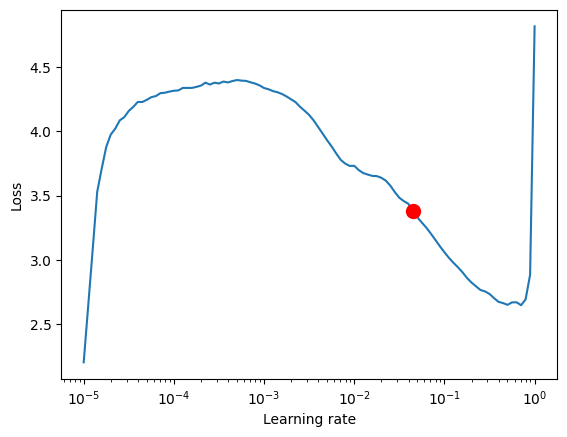

In [34]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

Fit model


In [35]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=3,
    accelerator="auto",
    enable_model_summary=True,
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=150
)


net = NBeats.from_dataset(
    training,
    learning_rate=1e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
    optimizer='adam'
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.851     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name            | Type       | Params
-------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


### Evaluate Results


In [17]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [18]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


tensor(0.4447)

In [36]:
save_path = trainer.checkpoint_callback.best_model_path
best_tft = net.load_from_checkpoint(save_path)

In [37]:
best_tft.interpret_output(predictions)

AttributeError: ignored

Looking at random samples from the validation set is always a good way to understand if the forecast is reasonable - and it is!


In [52]:
#raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)
output = best_model.predict(val_dataloader, mode="raw", return_x=True)
raw_predictions = output.output
x = output.x
#raw_predictions, x = best_model.predict(val_dataloader,  return_x=True)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [46]:
raw_predictions

tensor([[ 1.5868,  1.5869,  1.5870,  ...,  1.5888,  1.5889,  1.5890],
        [ 0.7022,  0.7023,  0.7024,  ...,  0.7036,  0.7037,  0.7037],
        [ 0.4781,  0.4762,  0.4744,  ...,  0.4485,  0.4469,  0.4453],
        ...,
        [ 1.3629,  1.3622,  1.3615,  ...,  1.3518,  1.3512,  1.3506],
        [-0.0295, -0.0294, -0.0294,  ..., -0.0291, -0.0290, -0.0290],
        [-4.2697, -4.2721, -4.2745,  ..., -4.3076, -4.3097, -4.3117]])

In [53]:
raw_predictions

Output(prediction=tensor([[ 1.5868,  1.5869,  1.5870,  ...,  1.5888,  1.5889,  1.5890],
        [ 0.7022,  0.7023,  0.7024,  ...,  0.7036,  0.7037,  0.7037],
        [ 0.4781,  0.4762,  0.4744,  ...,  0.4485,  0.4469,  0.4453],
        ...,
        [ 1.3629,  1.3622,  1.3615,  ...,  1.3518,  1.3512,  1.3506],
        [-0.0295, -0.0294, -0.0294,  ..., -0.0291, -0.0290, -0.0290],
        [-4.2697, -4.2721, -4.2745,  ..., -4.3076, -4.3097, -4.3117]]), backcast=tensor([[ 1.5789,  1.5790,  1.5792,  ...,  1.5864,  1.5865,  1.5866],
        [ 0.6970,  0.6970,  0.6971,  ...,  0.7020,  0.7021,  0.7021],
        [ 0.6209,  0.6180,  0.6151,  ...,  0.4838,  0.4819,  0.4800],
        ...,
        [ 1.4171,  1.4160,  1.4149,  ...,  1.3650,  1.3643,  1.3636],
        [-0.0310, -0.0310, -0.0310,  ..., -0.0295, -0.0295, -0.0295],
        [-4.0869, -4.0906, -4.0942,  ..., -4.2624, -4.2649, -4.2673]]), trend=tensor([[ 1.5789,  1.5790,  1.5792,  ...,  1.5888,  1.5889,  1.5890],
        [ 0.6970,  0.6970, 

In [54]:
x

{'encoder_cat': tensor([], size=(100, 60, 0), dtype=torch.int64),
 'encoder_cont': tensor([[[-0.7497],
          [-1.6123],
          [-1.5671],
          ...,
          [ 0.7031],
          [ 0.9691],
          [ 1.5556]],
 
         [[ 0.1395],
          [-0.0690],
          [-0.4312],
          ...,
          [ 0.0875],
          [ 0.0052],
          [ 0.1752]],
 
         [[-0.1526],
          [ 0.0155],
          [ 0.1195],
          ...,
          [ 0.6249],
          [ 0.0593],
          [-0.1615]],
 
         ...,
 
         [[-0.6037],
          [-0.1355],
          [-0.1665],
          ...,
          [ 0.5025],
          [ 1.6788],
          [ 0.4118]],
 
         [[ 0.3336],
          [ 0.0736],
          [-0.1639],
          ...,
          [-0.4222],
          [-0.1183],
          [ 0.0739]],
 
         [[ 0.8496],
          [ 0.8912],
          [ 0.8163],
          ...,
          [-0.5036],
          [-0.9404],
          [-1.3623]]]),
 'encoder_target': tensor([[ 1.3035,  

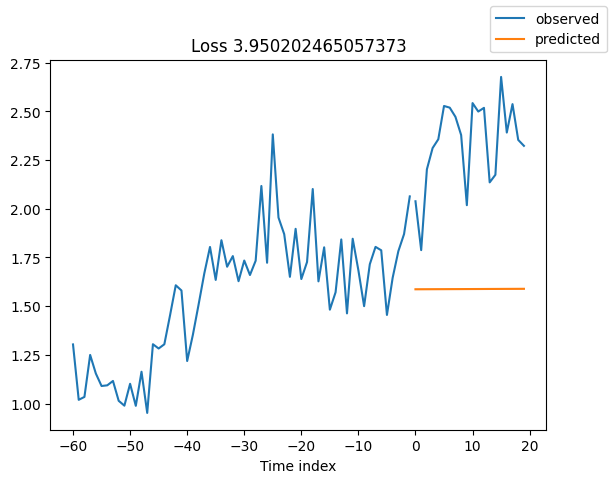

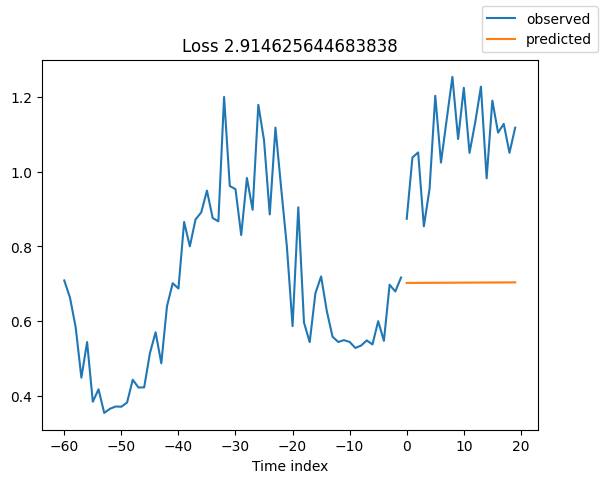

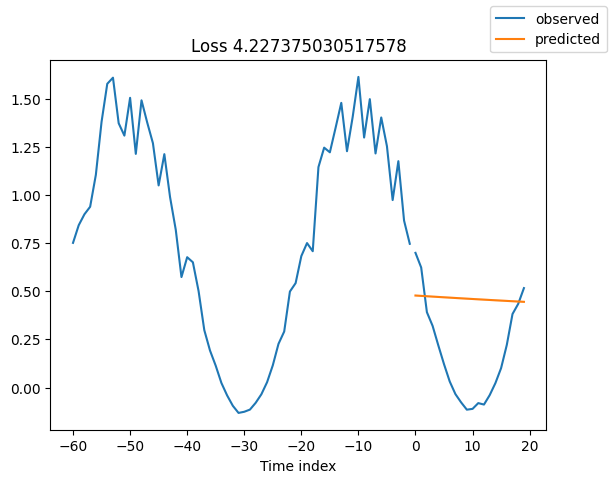

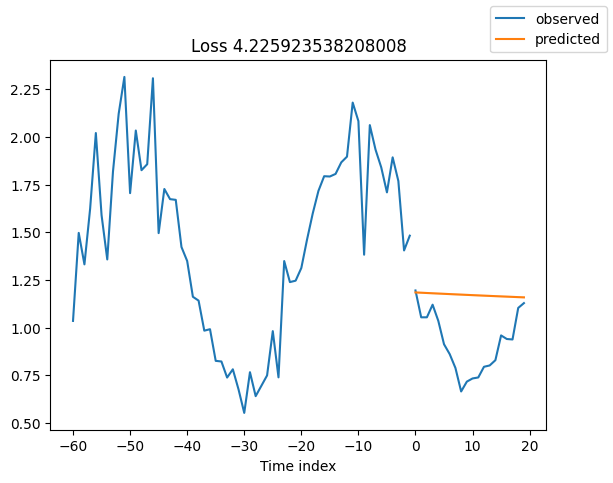

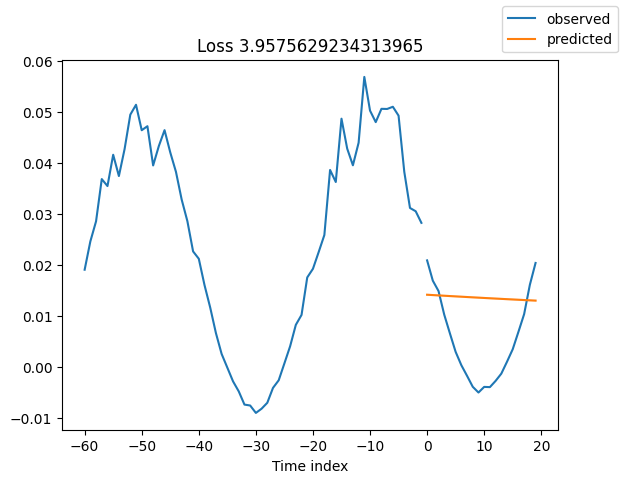

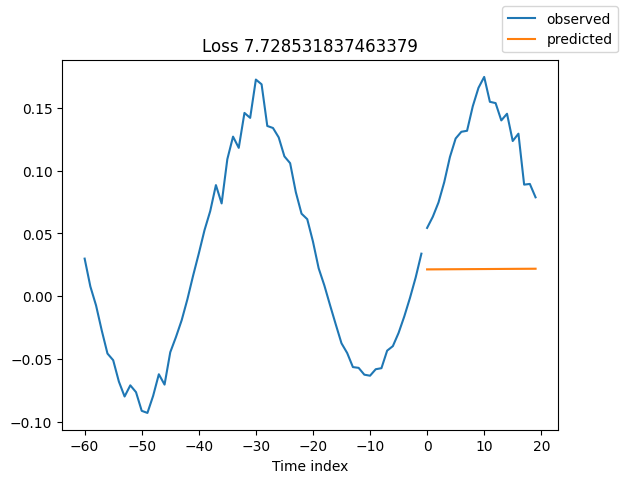

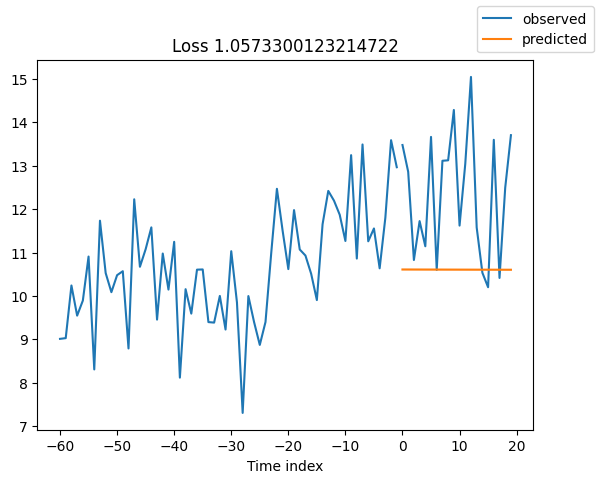

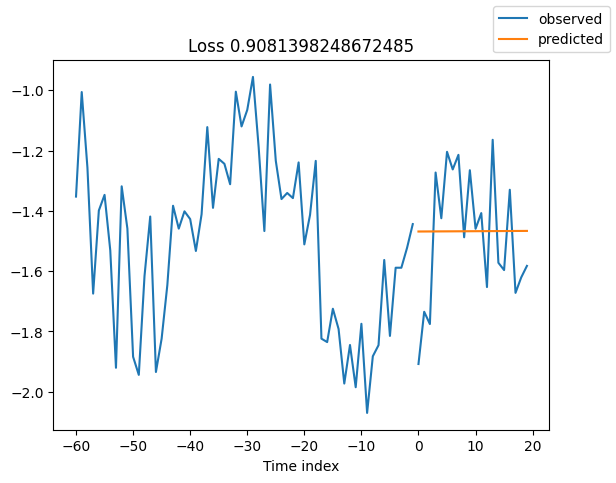

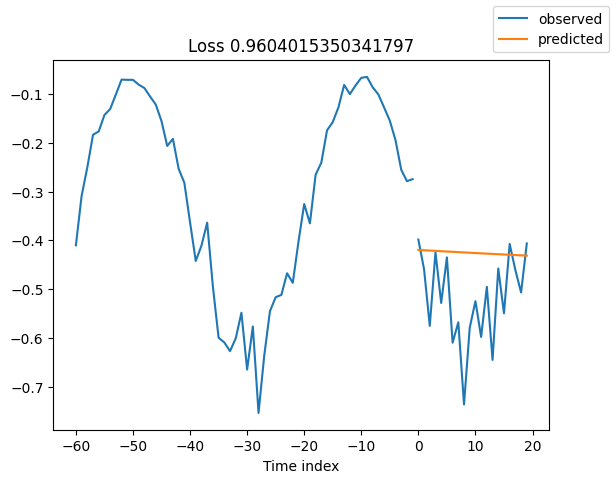

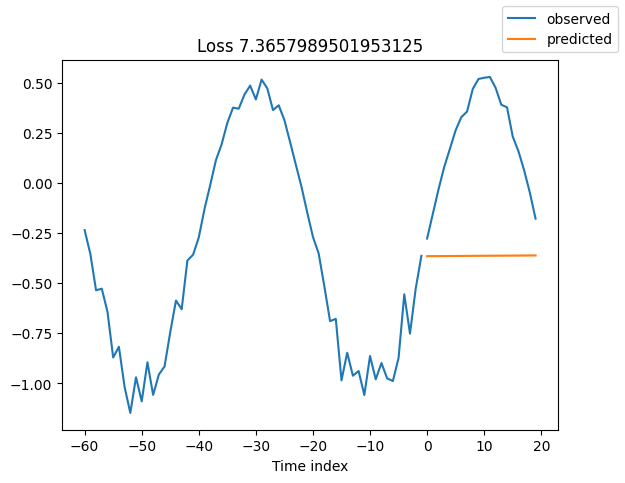

In [55]:
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)

## Interpret model


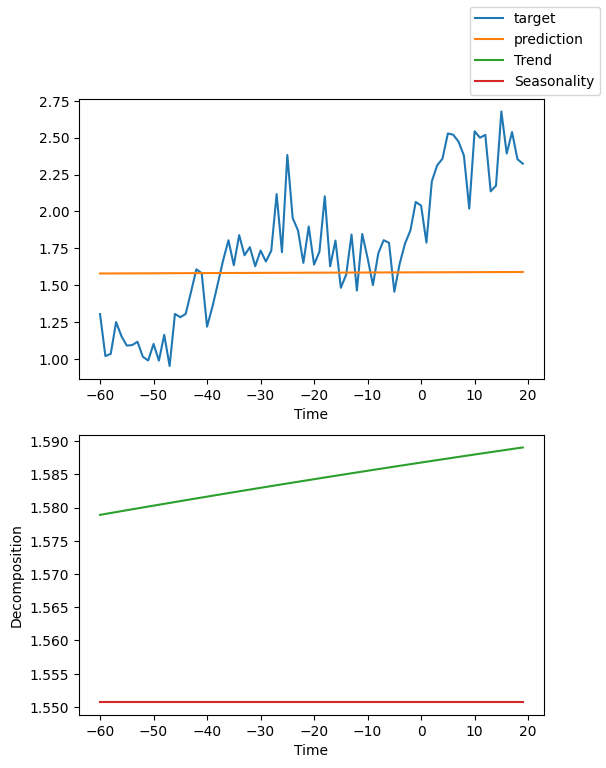

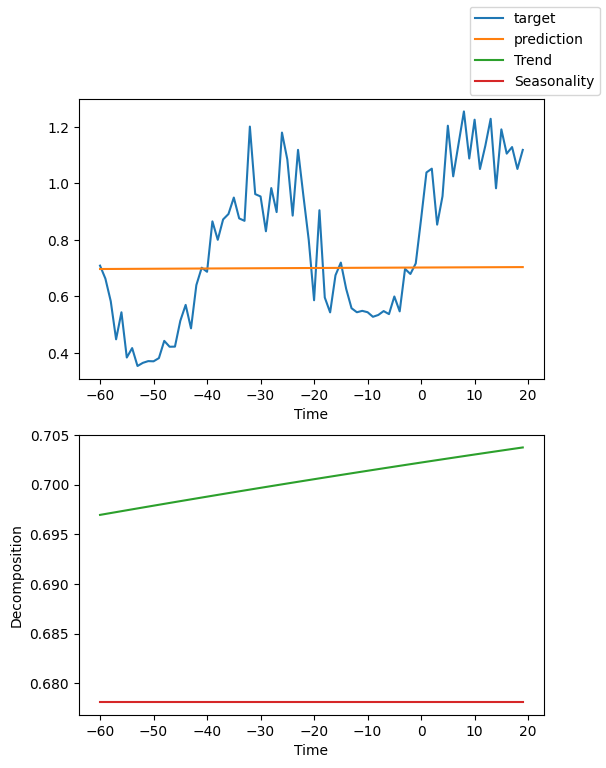

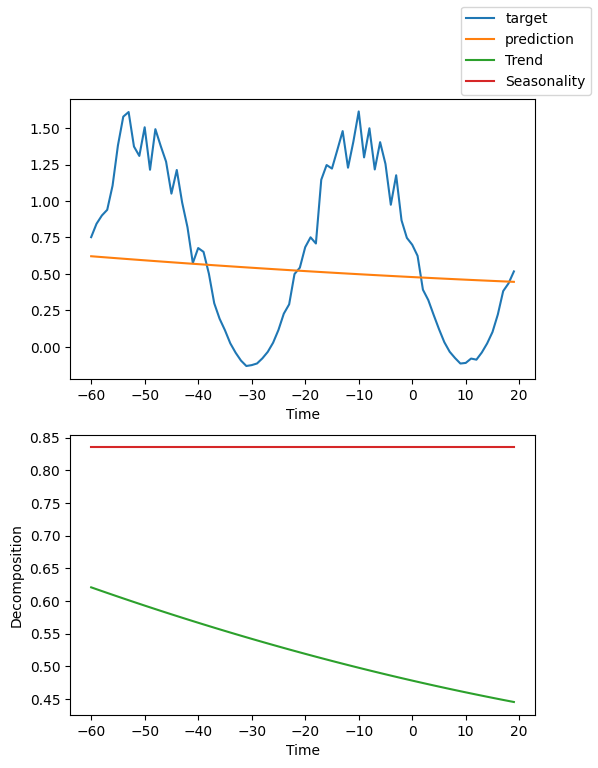

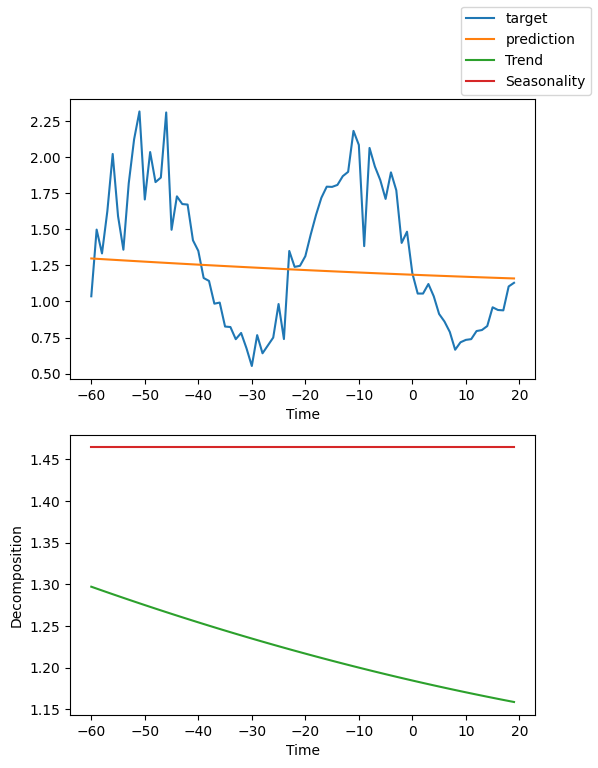

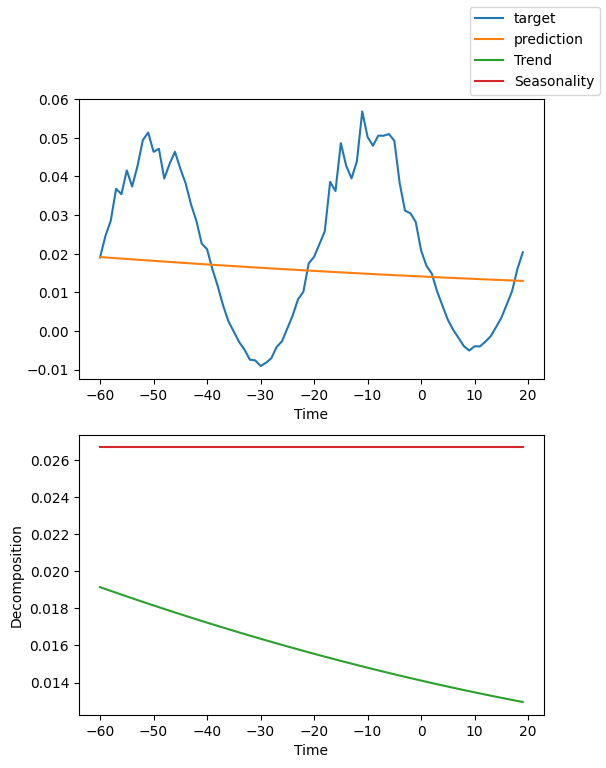

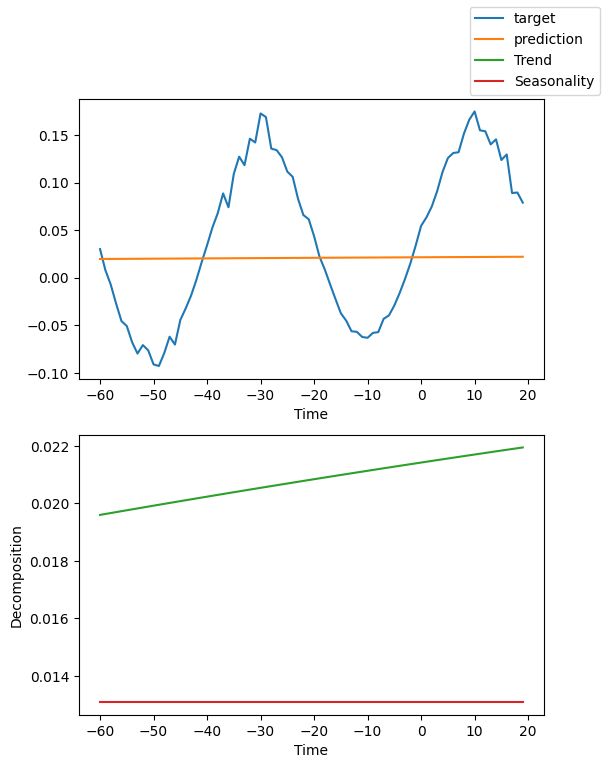

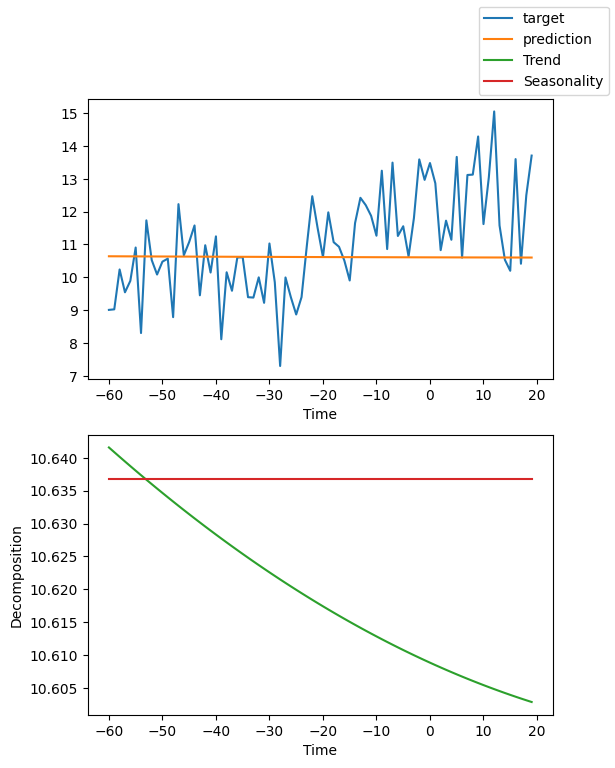

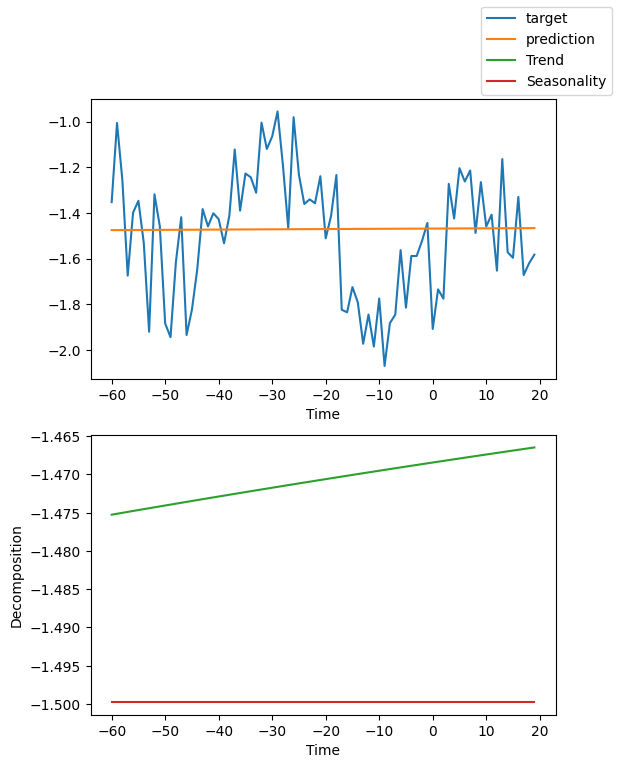

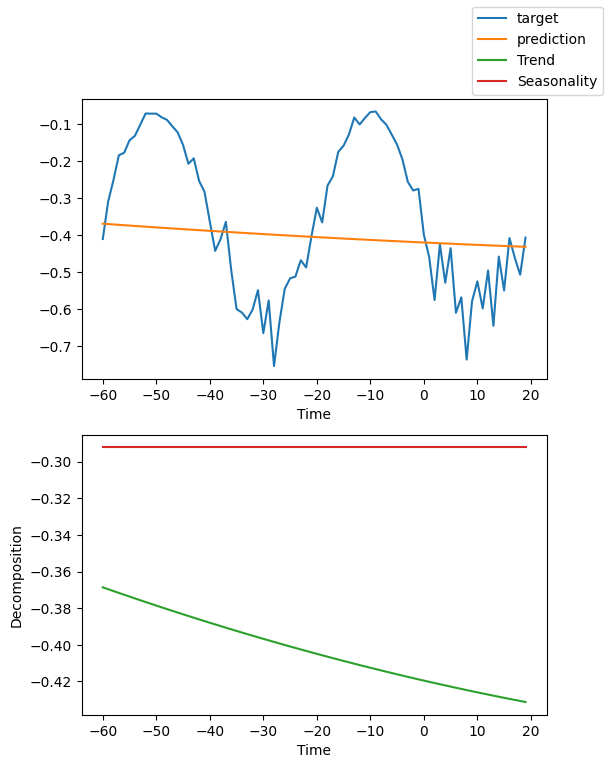

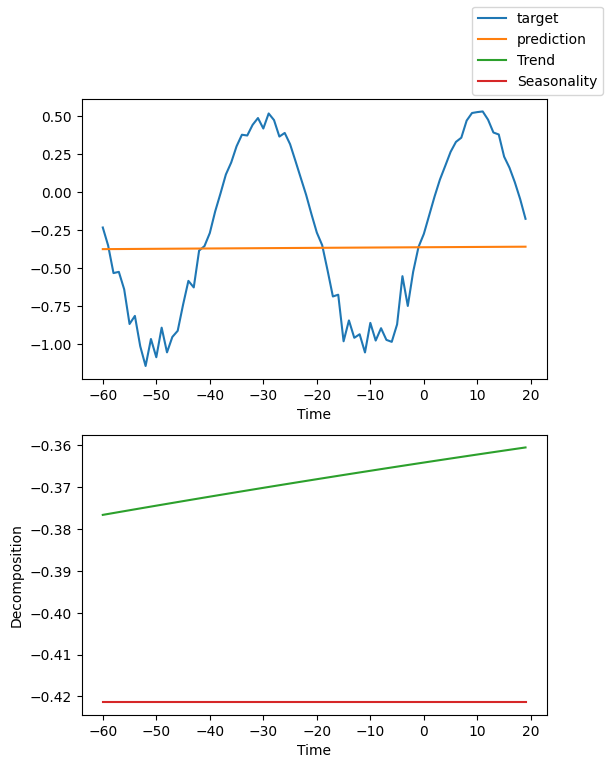

In [56]:
for idx in range(10):  # plot 10 examples
    best_model.plot_interpretation(x, raw_predictions, idx=idx)